In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-article/cleaned_file.csv


In [3]:
import os
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/kaggle/input/news-article/cleaned_file.csv',encoding='latin-1')
df['sentiments'] = df['sentiments'].map({'negative':-1.0,'neutral':0.0,'positive':1.0})
df.head()

,topic,title,source,article_link,article,sentiments
0,Microsoft,The Top 7 Tech Stocks to Buy in March 2024,InvestorPlace,https://investorplace.com/2024/03/the-top-7-te...,Microsoft (MSFT) is still growing at a fast pa...,1.0
1,Microsoft,Microsoft-owned LinkedIn makes this 'first-eve...,Times of India,https://timesofindia.indiatimes.com/gadgets-ne...,Microsoft-owned LinkedIn generated $1.7 billio...,1.0
2,Microsoft,Microsoft debuts Copilot for finance pros,Computerworld,https://www.computerworld.com/article/3714142/...,Microsoft has launched a Copilot assistant for...,0.0
3,Microsoft,Microsoft's Path to Becoming the Largest Compa...,The Motley Fool,https://www.fool.com/investing/2024/03/06/micr...,Microsoft's Path to Becoming the Largest Compa...,1.0
4,Microsoft,Top Analyst Brad Reback Weighs in on Microsoft...,Tipranks,https://www.tipranks.com/news/top-analyst-brad...,Non-deal roadshows (NDRs) allow institutional ...,1.0


In [5]:
df.isnull().sum()

topic           0
title           0
source          0
article_link    0
article         1
sentiments      0
dtype: int64

In [6]:
df.dropna(axis=0,inplace=True)
df = df[['title','sentiments']]
df.shape

(9268, 2)

In [7]:
df.groupby('sentiments').count().plot(kind='bar')

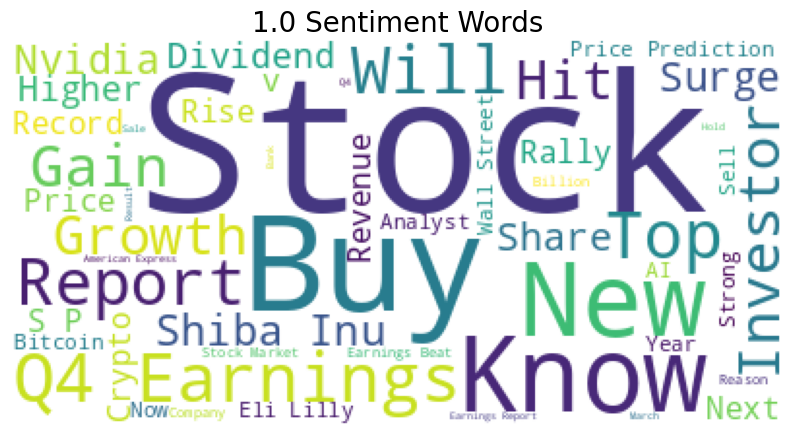

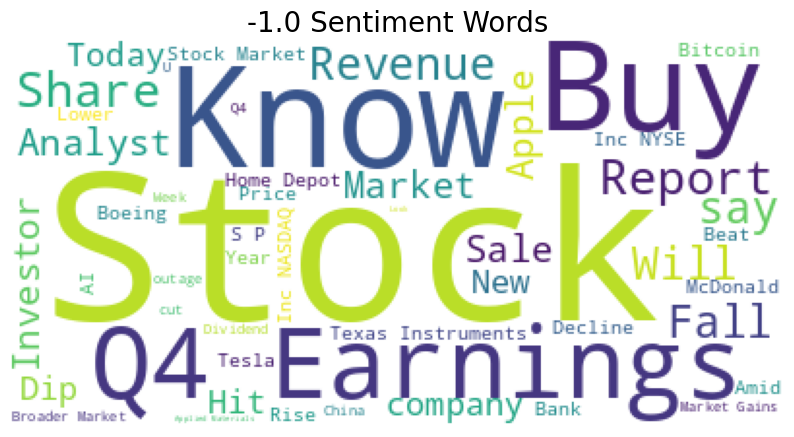

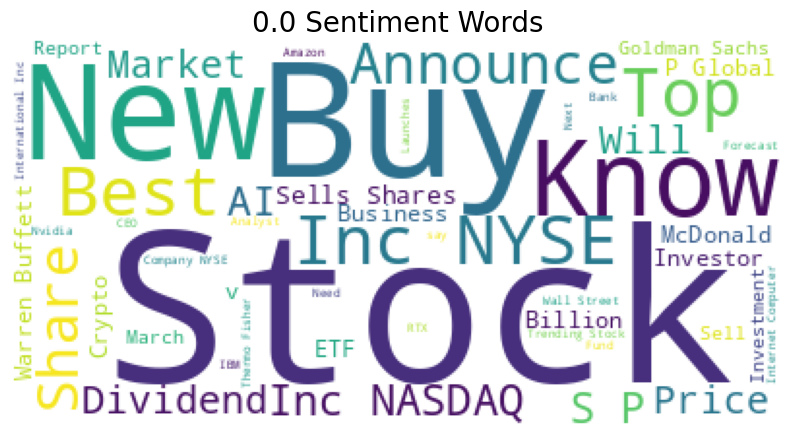

In [8]:
from wordcloud import WordCloud, STOPWORDS
def wordcount_gen(df,category):
    combined_tweets = " ".join([tweet for tweet in df[df.sentiments==category]['title']])
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 1.0)
     
# Negative tweet words
wordcount_gen(df, -1.0)
     
# Neutral tweet words
wordcount_gen(df, 0.0)

In [20]:
import spacy
nlp = spacy.load("en_core_web_sm")
def title_to_words(title):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = title.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = nlp(text)
    words = [token.text for token in text if token.pos_=='ADJ']
    # tokenize
    #words = text.split()
    
    # remove stopwords
    #words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    #words = [PorterStemmer().stem(w) for w in words]
    # return list
    
    return words

print("\nOriginal tweet ->", df['title'][0])
print("\nProcessed tweet ->", title_to_words(df['title'][0]))


Original tweet -> The Top 7 Tech Stocks to Buy in March 2024

Processed tweet -> ['top']


In [21]:
X = list(map(title_to_words, df['title']))
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['sentiments'])

In [22]:
print(X[0])
print(Y[0])

['top']
2


In [23]:
y = pd.get_dummies(df['sentiments'])
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

       -1.0    0.0    1.0
0     False  False   True
1     False  False   True
2     False   True  False
3     False  False   True
4     False  False   True
...     ...    ...    ...
9264  False   True  False
9265  False  False   True
9266  False   True  False
9267  False   True  False
9268  False   True  False

[9268 rows x 3 columns]


In [24]:
print(X_train[134])

['meta', 'xr']


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [49]:
print(count_vector.get_feature_names_out()[0:200])

['10th' '11th' '14th' '15th' '17th' '19th' '1st' '22nd' '3rd' '42nd'
 '44th' '45th' '49th' '4th' '51mn' '53bn' '5bn' '5x' '60th' '66th' '888k'
 'aacr' 'abbvi' 'abcam' 'abnb' 'absolut' 'academ' 'access' 'accur' 'acn'
 'action' 'activ' 'activist' 'addit' 'admir' 'adriat' 'advanc' 'advisori'
 'afford' 'ai' 'airbnb' 'aliv' 'alt' 'altern' 'amc' 'amd' 'american'
 'analyt' 'annual' 'anti' 'anticip' 'antitrust' 'aotearoa' 'appar' 'apt'
 'ar' 'aramco' 'argu' 'artifici' 'asian' 'assist' 'athlet' 'attract'
 'augusta' 'australian' 'autonom' 'avail' 'averag' 'back' 'backup' 'bad'
 'baffl' 'ballist' 'bankrupt' 'basic' 'bearish' 'beat' 'belov' 'benefici'
 'benign' 'berkshir' 'best' 'better' 'big' 'bigger' 'biggest' 'bionano'
 'biotech' 'bitcoin' 'bitter' 'bkng' 'black' 'bleak' 'blk' 'blockchain'
 'blue' 'bnb' 'bold' 'bragar' 'brand' 'breakthrough' 'bridgeft' 'brief'
 'bright' 'brighter' 'brilliant' 'british' 'broad' 'broader' 'bullish'
 'buyback' 'buyout' 'caribbean' 'cashflow' 'caterpillar' 'cautiou

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=30

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['title'][0])
X, tokenizer = tokenize_pad_sequences(df['title'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 The Top 7 Tech Stocks to Buy in March 2024
After Tokenization & Padding 
 [  3  41 163 304  23   1  14   4 131  22   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [51]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [52]:
y = pd.get_dummies(df['sentiments'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (5560, 30) (5560, 3)
Validation Set -> (1854, 30) (1854, 3)
Test Set -> (1854, 30) (1854, 3)


In [53]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [54]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=100
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_shape=(max_len,)))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning:

Argument `decay` is no longer supported and will be ignored.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



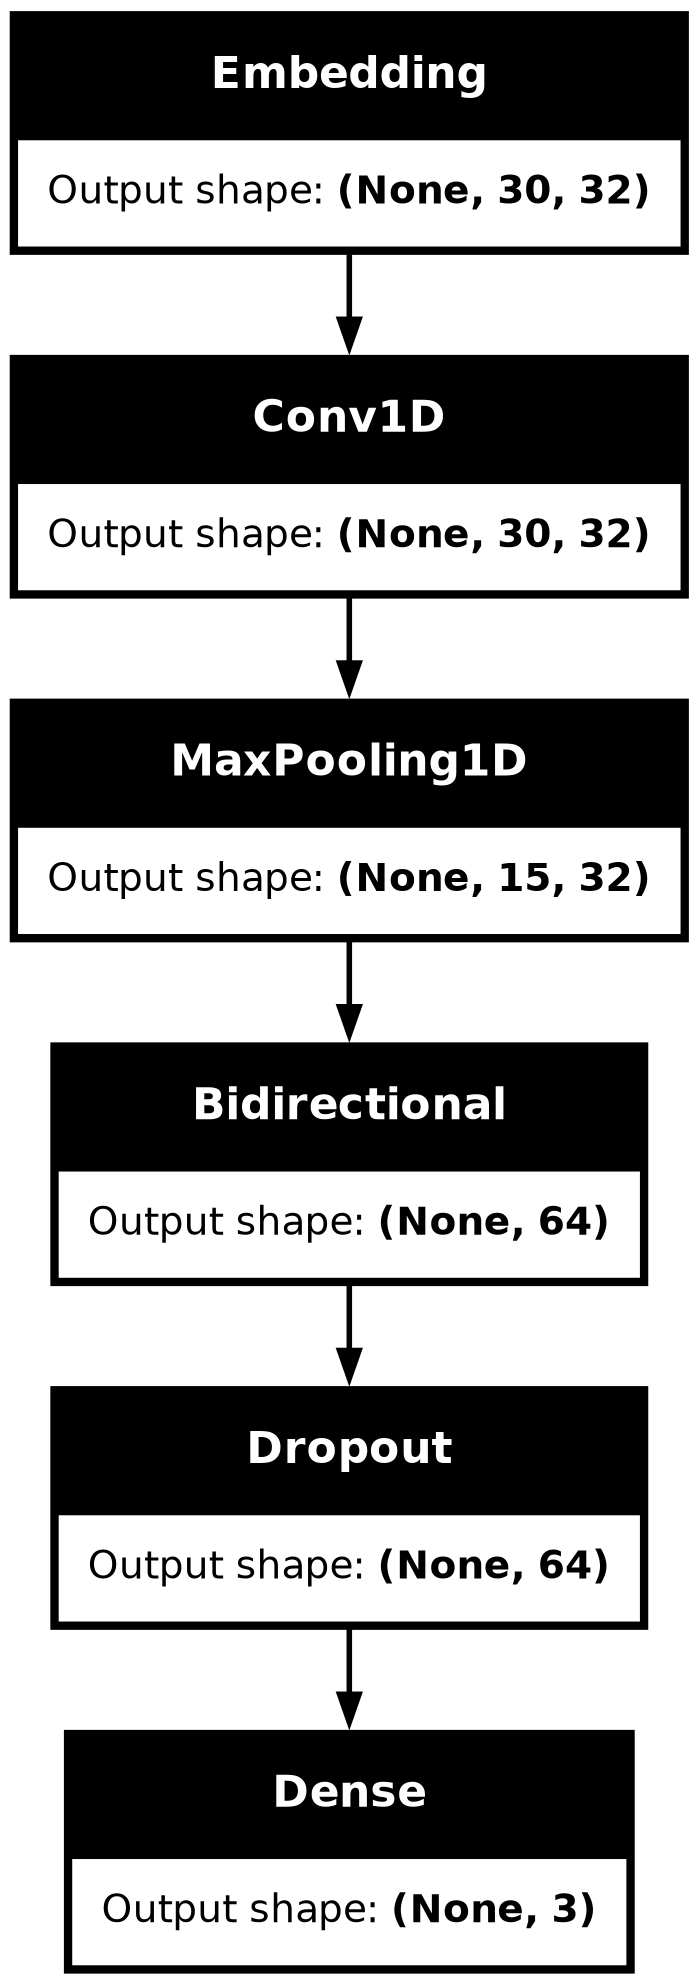

In [55]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [56]:
print(model.summary())
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 30, 32)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,939 (702.89 KB)

 Trainable params: 179,939 (702.89 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4088 - loss: 1.0890 - precision_1: 0.3906 - recall_1: 0.0023 - val_accuracy: 0.4008 - val_loss: 1.0892 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4304 - loss: 1.0817 - precision_1: 0.3067 - recall_1: 0.0014 - val_accuracy: 0.4008 - val_loss: 1.0885 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4131 - loss: 1.0880 - precision_1: 0.3254 - recall_1: 0.0043 - val_accuracy: 0.4008 - val_loss: 1.0906 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4230 - loss: 1.0834 - precision_1: 0.3326 - recall_1: 2.4068e-04 - val_accuracy: 0.4008 - val_loss: 1.0933 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4290 - loss: 1.0804 - pre

In [57]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.5469
Precision : 0.5474
Recall    : 0.5453
F1 Score  : 0.5463


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


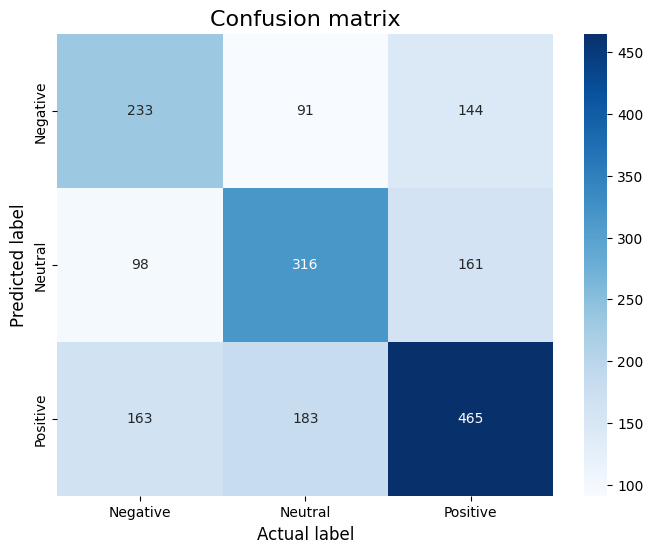

In [58]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [59]:
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=30
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])


In [60]:
predict_class(['"Microsoft is experience a steep decline in stock'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted sentiment is Negative
